<a href="https://colab.research.google.com/github/kevinball02/HUFS-ML-Project/blob/master/ANN_KYH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process

## 0. Basic Settings

지난번 과제에선, kaggle의 데이터셋을 github에 업로드 한 후, 이를 가져왔었다.  
이번에는, colab 환경에서 kaggle Dataset을 직접 다운로드 해서 사용해보겠다.

```
! kaggle datasets download -d iammustafatz/diabetes-prediction-dataset
```

위의 커맨드는 사전 설정을 해야 수행할 수 있다.  
'kaggle.json' (API Token)을 github에서 가져와 /root/.kaggle 경로로 옮기자.

In [ ]:
!git clone 'https://github.com/kevinball02/HUFS-ML-Project.git'

Cloning into 'HUFS-ML-Project'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 60 (delta 12), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (60/60), 6.16 MiB | 5.51 MiB/s, done.


In [ ]:
!mkdir -p ~/.kaggle
!mkdir -p ./result
!mv HUFS-ML-Project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d iammustafatz/diabetes-prediction-dataset
! unzip diabetes-prediction-dataset.zip

  0% 0.00/734k [00:00<?, ?B/s]
100% 734k/734k [00:00<00:00, 78.8MB/s]
Archive:  diabetes-prediction-dataset.zip
  inflating: diabetes_prediction_dataset.csv  


In [ ]:
#!pip install autoviz --upgrade
# 시각화를 자동으로 해주는 모듈. 하지만 여기선 쓰지 않았다.

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns

set_matplotlib_formats('svg')
plt.rcParams['axes.edgecolor'] = 'black'
sns.set_style("whitegrid")

from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1

In [ ]:
#AutoViz
 #from autoviz.AutoViz_Class import AutoViz_Class
#() import AutoViz
 #%matplotlib inline
#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.model_selection import train_test_split

#import tensorflow as tf
#from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.layers import Dropout

In [ ]:

raw_data = pd.read_csv('diabetes_prediction_dataset.csv')
raw_data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## 1. EDA & Preprocessing

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
data = raw_data.drop_duplicates() # 중복 제거
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96146 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.3+ MB


In [ ]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
exclusion = data.columns.difference(['age','bmi','HbA1c_level']) # 세 칼럼(float64)을 배재함.
for c in data[exclusion]:
  print(data[c].value_counts()); print('-'*30+'\n')

159    7478
130    7471
126    7421
140    7416
160    7397
145    7371
200    7290
155    7285
90     6822
80     6786
100    6774
158    6739
85     6632
280     724
300     673
260     634
240     633
220     600
Name: blood_glucose_level, dtype: int64
------------------------------

0    87664
1     8482
Name: diabetes, dtype: int64
------------------------------

Female    56161
Male      39967
Other        18
Name: gender, dtype: int64
------------------------------

0    92223
1     3923
Name: heart_disease, dtype: int64
------------------------------

0    88685
1     7461
Name: hypertension, dtype: int64
------------------------------

never          34398
No Info        32887
former          9299
current         9197
not current     6367
ever            3998
Name: smoking_history, dtype: int64
------------------------------



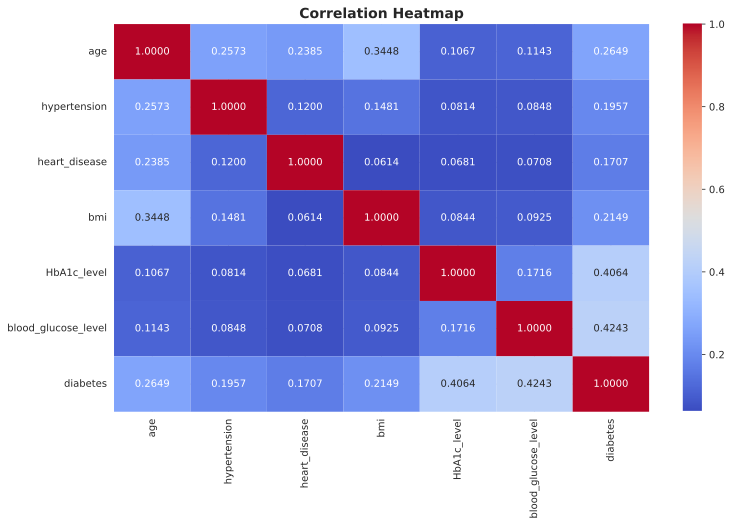

In [ ]:
numeric_cols = [x for x in data.dtypes.index if data.dtypes[x] != 'object']

plt.figure(figsize = (12,7))
sns.heatmap(data[numeric_cols].corr(), annot = True, fmt=".4f", cmap = 'coolwarm')
plt.title("Correlation Heatmap", fontsize = '14', fontweight= 'bold')
plt.show()

- - -
1) One-Hot Encoding for 'gender' & 'smoking_history'

In [ ]:
le = preprocessing.LabelEncoder()
data['gender'] = le.fit_transform(data['gender'])
data.gender.value_counts()

0    56161
1    39967
2       18
Name: gender, dtype: int64

In [ ]:
# 흡연 습관의 빈도에 따른 OneHot Encoding (유사성을 기준으로 분류)
smoking_history_mapping = {'No Info': np.nan, 'never': 0, 'not current': 0, 'former': 1, 'current': 2, 'ever': 2}
data.smoking_history = data['smoking_history'].map(smoking_history_mapping)

null_idx = data.smoking_history[data['smoking_history'].isnull()].index
data['smoking_history']

0        0.0
1        NaN
2        0.0
3        2.0
4        2.0
        ... 
99994    NaN
99996    NaN
99997    1.0
99998    0.0
99999    2.0
Name: smoking_history, Length: 96146, dtype: float64

In [ ]:
y = pd.get_dummies(data['diabetes'])
y

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
99994,1,0
99996,1,0
99997,1,0
99998,1,0


2) Missing Values in 'smoking_history'

In [ ]:
imputer = KNNImputer(n_neighbors=1)
filled_data = imputer.fit_transform(data)    # About 3m.
filled_data = pd.DataFrame(filled_data, index=data.index, columns=data.columns)
data['smoking_history'] = filled_data['smoking_history'].astype('int')

In [ ]:
data['smoking_history'][null_idx].value_counts()
# No Info를 아래와 같이 채웠다.

0    25353
2     4553
1     2981
Name: smoking_history, dtype: int64

In [ ]:
#'age' 칼럼을 정수화한다.
data.age = data['age'].astype('int')

3) Remove Outliers of 'bmi'

In [ ]:
bmi_vec = data['bmi']

In [ ]:
# Boxplot의 사분위를 사용하여 outlier 범위를 설정한다.
Q1 = bmi_vec.quantile(0.25)
Q3 = bmi_vec.quantile(0.75)
IQR = Q3 - Q1; epsilon = 1.5 * IQR
outlier_bool = ((bmi_vec < Q1 - epsilon) | (bmi_vec > Q3 + epsilon))
outlier = bmi_vec[outlier_bool]
outlier

11       54.70
39       56.43
59       63.48
93       55.61
98       50.13
         ...  
99933    13.34
99948    39.62
99953    60.52
99960    45.15
99993    40.69
Name: bmi, Length: 5354, dtype: float64

In [ ]:
data.drop(outlier.index, inplace=True)

4) Visualization by referring Corr. Matrix

* Notable Relationships
  * diabetes & blood_glucose_level  (0.4243)
  * diabetes & HbA1c_level  (0.4064)
  * diabetes & age  (0.2649)
  - - -
  * age & bmi  (0.3448)
  * age & hypertension  (0.2573)
  * age & heart_disease  (0.2385)

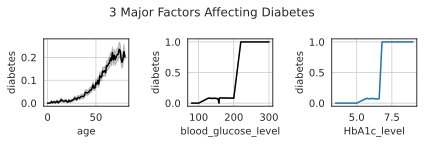

In [ ]:
%matplotlib inline
fig = plt.figure(figsize= (6,2))

ax = plt.subplot(1,3,1)
sns.lineplot(x= data['age'], y= data['diabetes'], color= "black")

plt.subplot(1,3,2)
sns.lineplot(x= data['blood_glucose_level'], y= data['diabetes'], color= 'black')

plt.subplot(1,3,3)
sns.lineplot(x= data['HbA1c_level'], y= data['diabetes'])

plt.suptitle("3 Major Factors Affecting Diabetes")

plt.tight_layout()
plt.savefig('major_factors_affecting_diabetes.png', facecolor='#eeeeee')
plt.show()

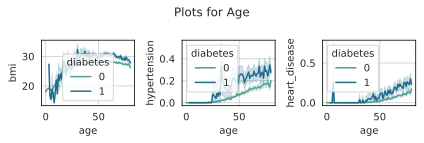

In [ ]:
%matplotlib inline
fig = plt.figure(figsize= (6,2))

ax = plt.subplot(1,3,1)
plt.subplot(1,3,1)
sns.lineplot(x = data['age'], y =  data['bmi'], hue = data['diabetes'], palette='crest')


plt.subplot(1,3,2)
sns.lineplot(x = data['age'], y =  data['hypertension'], hue = data['diabetes'], palette='crest')

plt.subplot(1,3,3)
sns.lineplot(x = data['age'],y = data['heart_disease'], hue = data['diabetes'], palette='crest')

plt.suptitle("Plots for Age")

plt.tight_layout()
plt.savefig('plots_for_age.png', facecolor='#eeeeee')
plt.show()

## 2. Create Basic ANN Model

In [ ]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80,0,1,0,25.19,6.6,140,0
1,0,54,0,0,0,27.32,6.6,80,0
2,1,28,0,0,0,27.32,5.7,158,0
3,0,36,0,0,2,23.45,5.0,155,0
4,1,76,1,1,2,20.14,4.8,155,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:,:-1], y[0], stratify=y[0], random_state=31)

In [ ]:
std = preprocessing.StandardScaler()
X_train = pd.DataFrame(data= std.fit_transform(X_train), columns= X_train.columns)
X_test = pd.DataFrame(data= std.transform(X_test), columns= X_test.columns)

In [ ]:
basic_ann = Sequential()

basic_ann.add(Dense(6, activation='relu'))
basic_ann.add(Dense(6, activation='relu'))
basic_ann.add(Dense(1, activation='sigmoid'))

basic_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_basic_ann = basic_ann.fit(X_train, y_train, epochs=100, batch_size=100, 
                  validation_data = (X_test, y_test), 
                  callbacks=[early_stop])

Epoch 1/100
681/681 [==============================] - 3s 3ms/step - loss: 0.2711 - accuracy: 0.9053 - val_loss: 0.1679 - val_accuracy: 0.9209
Epoch 2/100
681/681 [==============================] - 2s 2ms/step - loss: 0.1370 - accuracy: 0.9472 - val_loss: 0.1221 - val_accuracy: 0.9574
Epoch 3/100
681/681 [==============================] - 2s 3ms/step - loss: 0.1159 - accuracy: 0.9602 - val_loss: 0.1164 - val_accuracy: 0.9601
Epoch 4/100
681/681 [==============================] - 2s 4ms/step - loss: 0.1123 - accuracy: 0.9615 - val_loss: 0.1143 - val_accuracy: 0.9615
Epoch 5/100
681/681 [==============================] - 2s 3ms/step - loss: 0.1108 - accuracy: 0.9626 - val_loss: 0.1136 - val_accuracy: 0.9613
Epoch 6/100
681/681 [==============================] - 2s 2ms/step - loss: 0.1101 - accuracy: 0.9625 - val_loss: 0.1132 - val_accuracy: 0.9620
Epoch 7/100
681/681 [==============================] - 2s 2ms/step - loss: 0.1100 - accuracy: 0.9628 - val_loss: 0.1125 - val_accuracy: 0.9615

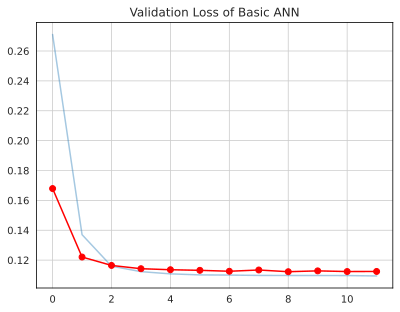

In [ ]:
train_loss = history_basic_ann.history['loss']
val_loss = history_basic_ann.history['val_loss']

x_len = np.arange(len(train_loss))

plt.plot(x_len,train_loss, alpha=0.4)
plt.plot(x_len,val_loss, marker='o', c="red")

plt.title('Validation Loss of Basic ANN')

plt.savefig('validation_loss_of_basic_ann.png', facecolor='#eeeeee')
plt.show()

In [ ]:
confusion_matrix(y_test, basic_ann.predict(X_test).round())

710/710 [==============================] - 2s 2ms/step


array([[ 1089,   715],
       [  153, 20741]])

In [ ]:
def basic_build_fn():
  ''' Creates model. '''
  model = Sequential()
  
  model.add(Dense(6, activation='relu'))
  model.add(Dense(6, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
  
  return model

In [ ]:
kcross_val_model = KerasClassifier(build_fn=basic_build_fn, epochs=20, batch_size=200, verbose=1)
kfold = KFold(n_splits=5, shuffle=True, random_state=31)

results = cross_val_score(kcross_val_model, X_train, y_train, cv=kfold)
print("결과",results)

Epoch 1/20
273/273 [==============================] - 1s 2ms/step - loss: 0.5644 - accuracy: 0.7694
Epoch 2/20
273/273 [==============================] - 1s 2ms/step - loss: 0.2353 - accuracy: 0.9445
Epoch 3/20
273/273 [==============================] - 1s 2ms/step - loss: 0.1342 - accuracy: 0.9593
Epoch 4/20
273/273 [==============================] - 1s 2ms/step - loss: 0.1159 - accuracy: 0.9617
Epoch 5/20
273/273 [==============================] - 1s 2ms/step - loss: 0.1121 - accuracy: 0.9622
Epoch 6/20
273/273 [==============================] - 1s 2ms/step - loss: 0.1110 - accuracy: 0.9622
Epoch 7/20
273/273 [==============================] - 1s 2ms/step - loss: 0.1105 - accuracy: 0.9626
Epoch 8/20
273/273 [==============================] - 1s 2ms/step - loss: 0.1101 - accuracy: 0.9625
Epoch 9/20
273/273 [==============================] - 1s 3ms/step - loss: 0.1099 - accuracy: 0.9628
Epoch 10/20
273/273 [==============================] - 1s 3ms/step - loss: 0.1096 - accuracy: 0.9627

In [ ]:
my_ann = Sequential()

my_ann.add(BatchNormalization())
my_ann.add(Dense(6, activation='relu', 
                 kernel_initializer='he_normal', 
                 kernel_regularizer=l1(0.01)))
my_ann.add(BatchNormalization())
my_ann.add(Dense(6, activation='relu', 
                 kernel_initializer='he_normal', 
                 kernel_regularizer=l1(0.01)))
my_ann.add(BatchNormalization())
my_ann.add(Dense(1, activation='sigmoid'))

my_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_my_ann = my_ann.fit(X_train, y_train, epochs=100, batch_size=100, 
                  validation_data = (X_test, y_test), 
                  callbacks=[early_stop])

Epoch 1/100
681/681 [==============================] - 6s 5ms/step - loss: 0.5121 - accuracy: 0.8906 - val_loss: 0.2434 - val_accuracy: 0.9616
Epoch 2/100
681/681 [==============================] - 2s 3ms/step - loss: 0.1924 - accuracy: 0.9556 - val_loss: 0.1511 - val_accuracy: 0.9608
Epoch 3/100
681/681 [==============================] - 2s 3ms/step - loss: 0.1434 - accuracy: 0.9575 - val_loss: 0.1264 - val_accuracy: 0.9618
Epoch 4/100
681/681 [==============================] - 2s 3ms/step - loss: 0.1303 - accuracy: 0.9572 - val_loss: 0.1201 - val_accuracy: 0.9618
Epoch 5/100
681/681 [==============================] - 2s 3ms/step - loss: 0.1245 - accuracy: 0.9577 - val_loss: 0.1176 - val_accuracy: 0.9609
Epoch 6/100
681/681 [==============================] - 2s 3ms/step - loss: 0.1225 - accuracy: 0.9580 - val_loss: 0.1173 - val_accuracy: 0.9618
Epoch 7/100
681/681 [==============================] - 3s 5ms/step - loss: 0.1213 - accuracy: 0.9589 - val_loss: 0.1155 - val_accuracy: 0.9618

In [ ]:
basic_loss, basic_accuracy = basic_ann.evaluate(X_test, y_test)
print(f'Test loss of basic_ann: {basic_loss:.4f}')
print(f'Test accuracy basic_ann: {basic_accuracy:.4f}')

my_loss, my_accuracy = my_ann.evaluate(X_test, y_test)
print(f'Test loss of my_ann: {my_loss:.4f}')
print(f'Test accuracy my_ann: {my_accuracy:.4f}')

710/710 [==============================] - 2s 3ms/step - loss: 0.0858 - accuracy: 0.9734
Test loss of basic_ann: 0.0858
Test accuracy basic_ann: 0.9734
710/710 [==============================] - 1s 2ms/step - loss: 0.1040 - accuracy: 0.9667
Test loss of my_ann: 0.1040
Test accuracy my_ann: 0.9667


In [ ]:
dropout_ann = Sequential()

dropout_ann.add(Dropout(rate=0.2))
dropout_ann.add(Dense(6, activation='relu'))
dropout_ann.add(Dropout(rate=0.2))
dropout_ann.add(Dense(6, activation='relu'))
dropout_ann.add(Dropout(rate=0.2))
dropout_ann.add(Dense(1, activation='sigmoid'))

dropout_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_dropout_ann = dropout_ann.fit(X_train, y_train, epochs=100, batch_size=100, 
                  validation_data = (X_test, y_test), 
                  callbacks=[early_stop])

Epoch 1/100
681/681 [==============================] - 3s 3ms/step - loss: 0.3357 - accuracy: 0.8878 - val_loss: 0.1687 - val_accuracy: 0.9205
Epoch 2/100
681/681 [==============================] - 2s 2ms/step - loss: 0.1896 - accuracy: 0.9359 - val_loss: 0.1367 - val_accuracy: 0.9487
Epoch 3/100
681/681 [==============================] - 2s 3ms/step - loss: 0.1766 - accuracy: 0.9415 - val_loss: 0.1307 - val_accuracy: 0.9511
Epoch 4/100
681/681 [==============================] - 3s 4ms/step - loss: 0.1699 - accuracy: 0.9412 - val_loss: 0.1266 - val_accuracy: 0.9555
Epoch 5/100
681/681 [==============================] - 2s 2ms/step - loss: 0.1660 - accuracy: 0.9411 - val_loss: 0.1225 - val_accuracy: 0.9575
Epoch 6/100
681/681 [==============================] - 2s 2ms/step - loss: 0.1626 - accuracy: 0.9419 - val_loss: 0.1223 - val_accuracy: 0.9566
Epoch 7/100
681/681 [==============================] - 2s 2ms/step - loss: 0.1602 - accuracy: 0.9418 - val_loss: 0.1182 - val_accuracy: 0.9581

In [ ]:
dropout_loss, dropout_accuracy = dropout_ann.evaluate(X_test, y_test)
print(f'Test loss of dropout_ann: {dropout_loss:.4f}')
print(f'Test accuracy dropout_ann: {dropout_accuracy:.4f}')

710/710 [==============================] - 1s 2ms/step - loss: 0.1135 - accuracy: 0.9576
Test loss of dropout_ann: 0.1135
Test accuracy dropout_ann: 0.9576


In [ ]:
weak_ann = basic_build_fn()

history_weak_ann = weak_ann.fit(X_train, y_train, epochs=1, batch_size=16, 
                  validation_data = (X_test, y_test))

4256/4256 [==============================] - 12s 2ms/step - loss: 0.1597 - accuracy: 0.9422 - val_loss: 0.1284 - val_accuracy: 0.9584


In [ ]:
def print_test_metrics(model, X_test):
  """Test 정확도와 Confusion Matrix를 출력하는 함수"""
  print('*** Test Accuracy *** \n   {}'.format(model.score(X_test, y_test)))
  print('\n*** Confusion Matrix *** \n', confusion_matrix(y_test, model.predict(X_test)))

In [ ]:
weak_ann_pred = weak_ann.predict(X_test).round()
confusion_matrix(y_test, weak_ann_pred)

710/710 [==============================] - 2s 3ms/step


array([[  968,   836],
       [  109, 20785]])

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, weak_ann_pred)

precisions, recalls, thresholds = precision_recall_curve(y_test, weak_ann_pred)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  '''ROC Curve를 그리는 함수'''
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)
  plt.grid(True)

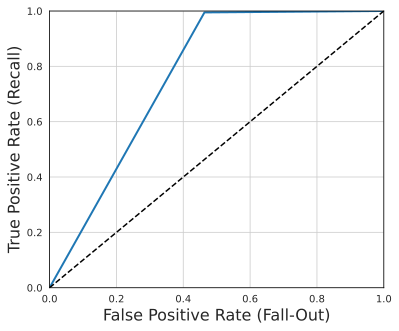

In [ ]:
plt.figure(figsize=(6, 5))
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print(f"roc auc value: {roc_auc_score(y_test, lr_pred):.5f}")

roc auc value: 0.80056


In [ ]:
def plot_precision_vs_recall(precisions, recalls):
  '''PR Curve를 그리는 함수'''
  plt.plot(recalls, precisions, "b-", linewidth=2)
  plt.xlabel("Recall", fontsize=16)
  plt.ylabel("Precision", fontsize=16)
  plt.axis([0, 1, 0, 1])
  plt.grid(True)

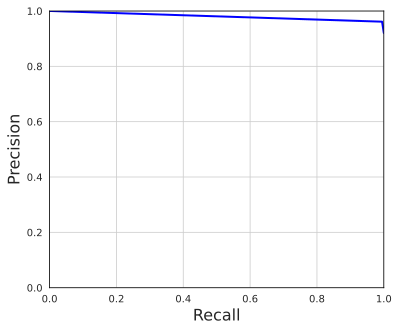

In [ ]:
plt.figure(figsize=(6, 5))
plot_precision_vs_recall(precisions, recalls)
plt.show()